# Using Linear Regression and Deep Neural Networks to model Fuel Emissions using TensorFlow

In this project, I experiment with using TensorFlow to build 4 different models to predict Fuel Emissions of over 22,000 cars built from 2000 to 2022. The data I'm using I'm using is model-specific fuel consumption ratings and estimated carbon dioxide emissions for new light-duty vehicles for retail sale in Canada sourced from the Government of Canada website (https://open.canada.ca/data/en/dataset/98f1a129-f628-4ce4-b24d-6f16bf24dd64). The four models I use are:
* Univariate Linear Regression with Fuel Consumption as the input feature
* Multivariate Lienar Regression with a total of X input features including Number of Cylinders and Engine Size
* Deep Neural Network with one input feature (Fuel Consumption)
* Deep Neural Network using all available input features

At the end, I evaluate each model by studying the test errors.

### **Step 1.** Import necessary libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__) # Check what version of TensorFlow we are using

2.18.0


In [3]:
dataset = pd.read_csv('Fuel_Data.csv')

dataset.head()

,YEAR,VEHICLE CLASS,ENGINE SIZE,CYLINDERS,FUEL,FUEL CONSUMPTION,HWY (L/100 km),COMB (L/100 km),COMB (mpg),EMISSIONS
0,2000,COMPACT,1.6,4,X,9.2,6.7,8.1,35,186
1,2000,COMPACT,1.6,4,X,8.5,6.5,7.6,37,175
2,2000,MID-SIZE,3.2,6,Z,12.2,7.4,10.0,28,230
3,2000,MID-SIZE,3.5,6,Z,13.4,9.2,11.5,25,264
4,2000,SUBCOMPACT,1.8,4,X,10.0,7.0,8.6,33,198


We can see we have a total of 10 columns which means 9 input features and 1 test feature (Emissions).
Vehicle Class and Fuel have categorical data. This means, we need to one-hot encode the values in these columns

In [4]:
dataset = pd.get_dummies(dataset, columns=['FUEL', 'VEHICLE CLASS'], prefix='', prefix_sep='', dtype=float)
dataset.head()

,YEAR,ENGINE SIZE,CYLINDERS,FUEL CONSUMPTION,HWY (L/100 km),COMB (L/100 km),COMB (mpg),EMISSIONS,D,E,...,SUV: Standard,Special purpose vehicle,Station wagon: Mid-size,Station wagon: Small,Subcompact,TWO-SEATER,Two-seater,VAN - CARGO,VAN - PASSENGER,Van: Passenger
0,2000,1.6,4,9.2,6.7,8.1,35,186,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2000,1.6,4,8.5,6.5,7.6,37,175,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2000,3.2,6,12.2,7.4,10.0,28,230,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2000,3.5,6,13.4,9.2,11.5,25,264,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2000,1.8,4,10.0,7.0,8.6,33,198,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We now have 44 input features and all data is numeric which is needed for training of the model. Let's now split our dataset into training data and test data with and 80% : 20% ratio

In [6]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

Let's quickly analyse the training data

In [ ]:
train_dataset.describe().transpose().head() # Remove.head() to view all statistics

,count,mean,std,min,25%,50%,75%,max
YEAR,18045.0,2011.561153,6.272951,2000.0,2006.0,2012.0,2017.0,2022.0
ENGINE SIZE,18045.0,3.353344,1.334836,0.8,2.3,3.0,4.2,8.4
CYLINDERS,18045.0,5.848933,1.814774,2.0,4.0,6.0,8.0,16.0
FUEL CONSUMPTION,18045.0,12.754231,3.499185,3.5,10.4,12.3,14.7,30.6
HWY (L/100 km),18045.0,8.914647,2.274733,3.2,7.3,8.4,10.2,20.9


Now, let's remove the target variable (Emissions) from the training data, whilst making a copy of teh original traing data

In [9]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('EMISSIONS')
test_labels = test_features.pop('EMISSIONS')

Next, let's normalize the data using the default Z-score normalization. This will make training of the model much more stable.

In [10]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))

Let's have a look at teh first 7 values of the first row in their raw form and normalized form

In [11]:
first_row = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first_row[0][:7])
  print()
  print('Normalized:', normalizer(first_row).numpy()[0][:7])

First example: [2003.     1.5    4.     8.3    6.     7.3   39. ]

Normalized: [-1.36 -1.39 -1.02 -1.27 -1.28 -1.28  1.56]


Cool, now let's experiment with predicting Fuel Emissions based of Fuel Consumption using Linear Regression. For this, method, it's easy to set up because we just need two layers: a normlaization layer and a linear regression layer.

In [12]:
Fuel_Consumption = np.array(train_features['FUEL CONSUMPTION']) # This is the one input feature we are using

# Normalization...
Fuel_Consumption_normalizer = layers.Normalization(input_shape=[1,], axis=None)
Fuel_Consumption_normalizer.adapt(Fuel_Consumption)

c:\Users\miloc\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Now we can build the TensorFlow model using Keras layers

In [13]:
Fuel_Consumption_model = tf.keras.Sequential([
    Fuel_Consumption_normalizer,
    layers.Dense(units=1) # units = 1 because we just want a single output. By default the activation here is a linear activation
])

# Show us a summary
Fuel_Consumption_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_1 (Normalization) │ (None, 1)              │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5 (24.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 3 (16.00 B)

Now let's build the model. TensorFlow will find the best weight and bias using a method of gradient descent which is sped up using the Adam algorithm. The learning rate has been set at 0.1 and we aim to minimise the mean squared error

In [14]:
Fuel_Consumption_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_squared_error')

Now let's train the model using 100 epochs and record the losses each. We use 20% of the traing data as a cross-validation set and we will record the validation error too

In [15]:
history = Fuel_Consumption_model.fit(
    train_features['FUEL CONSUMPTION'],
    train_labels,
    epochs=100,
    verbose=0, # Suppress logging.
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

Let's now plot the losses

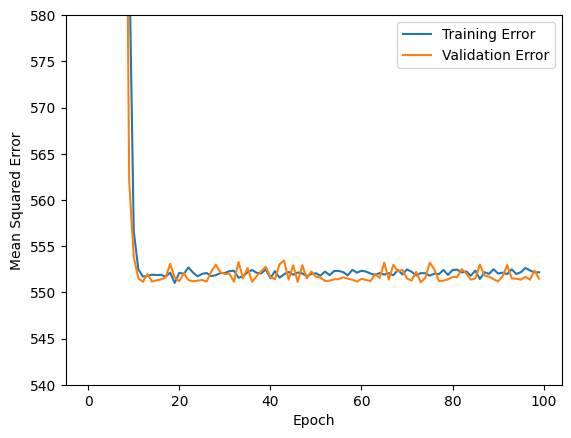

In [19]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
plt.plot(hist['loss'], label = 'Training Error')
plt.plot(hist['val_loss'], label = 'Validation Error')
plt.ylim(540,580)
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

Clearly the error is very high. This indicates our model is not very good, which makes sense as it is very simple, and has a high bias. Fortunately the validation error and training error are close together which indicates low variance. Let's now record our results in a dictionary and plot the model.

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


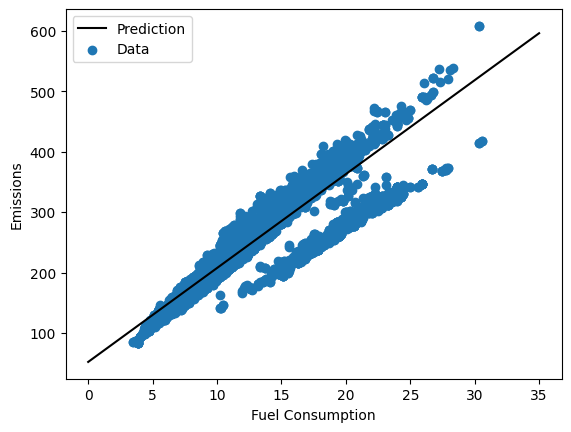

In [21]:
test_results = {}

test_results['Fuel_Consumption_model'] = Fuel_Consumption_model.evaluate(
    test_features['FUEL CONSUMPTION'],
    test_labels, verbose=0)

x = tf.linspace(0.0, 35, 36)
y = Fuel_Consumption_model.predict(x)

plt.plot(x,y, label = 'Prediction', color = 'k')
plt.scatter(train_features['FUEL CONSUMPTION'], train_labels, label = 'Data')
plt.xlabel('Fuel Consumption')
plt.ylabel('Emissions')
plt.legend()
plt.show()

The model is definitely working. It's clear why it's not very good though, it seems like the data is split into two groups. This may be linked to different Fuel types or number of cylinders. Hence, we need more input features to develop a better model.

### Multivariate Linear Regression
Now let's experiment with using all input features. For each feature, we'll need to normalize them and then pass them through a regression layer. Theoretically, with more features, the model should make better predictions.

In [23]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

Let's now build the model using the same optimizer, learning rate and loss definition

In [24]:
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_squared_error')

Let's now train the model on all available features using 20% of data for cross-validation.

In [25]:
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)

Now let's plot our data.

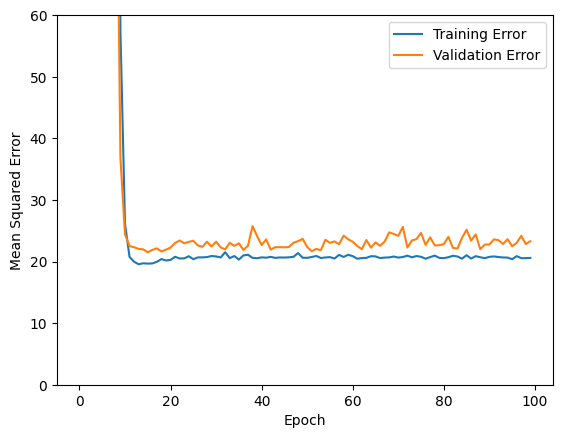

In [26]:
plt.plot(history.history['loss'], label = 'Training Error')
plt.plot(history.history['val_loss'], label = 'Validation Error')
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.legend()
plt.ylim(0,60)
plt.show()

The error has been significantly reduced which is fantastic. The validation error once again is close to the training error indicating low variance. As predicted multi-variate regression has made a much better prediction that univariate regression. Let's now record our results.

In [27]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

### Deep Neural Network with 1 Input Feature
Now, let's experiment with building, training, and testing a deep neural network to predict Fuel Emissions given just 1 input feature which is Fuel Consumption. For this DNN, we will use 4 layers: a Normalization layer, 2 layers with 64 units each and, a final layer with 1 unit because we desire just one output. We use ReLU activation functions for the hidden layers and aim to minimise the mean squared loss. This time, we use a lower learning rate of 0.001 and the Adam algorithm again for faster training.

In [28]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [29]:
dnn_Fuel_Consumption_model = build_and_compile_model(Fuel_Consumption_normalizer)

In [30]:
dnn_Fuel_Consumption_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_1 (Normalization) │ (None, 1)              │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,356 (17.02 KB)

 Trainable params: 4,353 (17.00 KB)

 Non-trainable params: 3 (16.00 B)

Let's now train the model and track the history of losses.

In [31]:
history = dnn_Fuel_Consumption_model.fit(
    train_features['FUEL CONSUMPTION'],
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

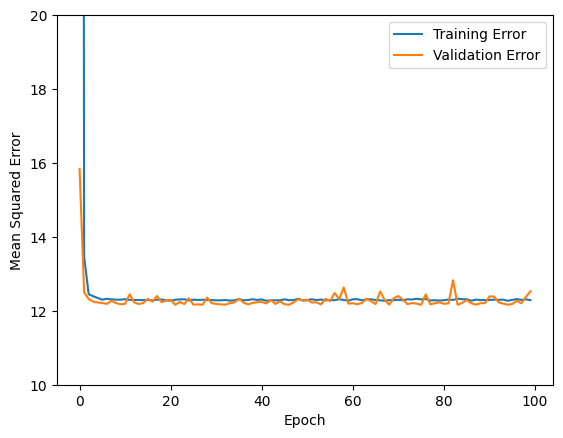

In [33]:
plt.plot(history.history['loss'], label = 'Training Error')
plt.plot(history.history['val_loss'], label = 'Validation Error')
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.legend()
plt.ylim(10,20)
plt.show()

This is a fantastic result. The error here compared to the error using univariate linear regression is significantly lower. Interestingly, the DNN error is even lower than the error for multivariate regression too. Once again the validation error and traing error are close, indicating low variance. Let's now plot our prediction against the raw data

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


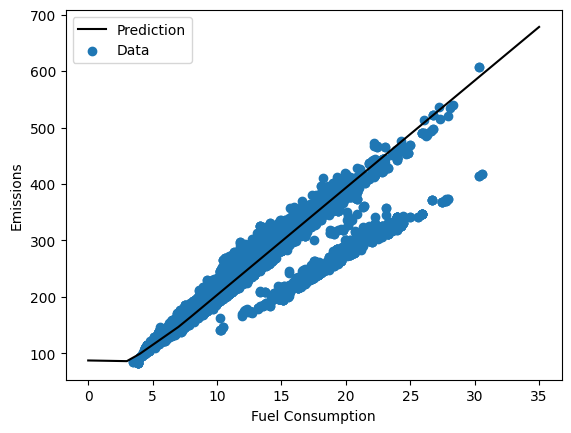

In [34]:
x = tf.linspace(0.0, 35, 36)
y = dnn_Fuel_Consumption_model.predict(x)

plt.plot(x,y, label = 'Prediction', color = 'k')
plt.scatter(train_features['FUEL CONSUMPTION'], train_labels, label = 'Data')
plt.xlabel('Fuel Consumption')
plt.ylabel('Emissions')
plt.legend()
plt.show()

Interestingly, the neural network prediction has decided to follow one of the clusters and the prediction is now a curved fit. Let's record thes results and move on.

In [35]:
test_results['dnn_Fuel_Consumption_model'] = dnn_Fuel_Consumption_model.evaluate(
    test_features['FUEL CONSUMPTION'], test_labels,
    verbose=0)

### Deep Neural Network with multiple input features
Finally, we build a neural network model that uses all available data as input features. This should theoretically be the best model. The neural network has an idnetical structure to the previous network, we're just adding more types of data this time.

In [36]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 44)             │            89 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 89 (360.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 89 (360.00 B)

Let's train this model which will take a few minutes.

In [37]:
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

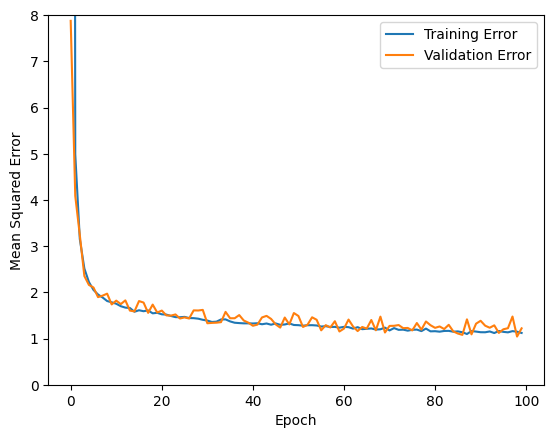

In [38]:
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.plot(history.history['loss'], label = 'Training Error')
plt.plot(history.history['val_loss'], label = 'Validation Error')
plt.legend()
plt.ylim(0,8)
plt.show()

This is a significantly lower error and teh model clearly has low variance again. Let's record this model in the dictionary.

In [39]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

Here is a summary of the errors the midels made on the testing data:

In [40]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
Fuel_Consumption_model,529.322998
linear_model,22.722317
dnn_Fuel_Consumption_model,12.084939
dnn_model,1.214097


As you can see, the final model (Deep Neural Network with multiple inout features) is the best by a long way. This just goes to show how powerful neural networks are in making predictions. Finally, let's plot the true Fuel Emission valeus against our predicted value using the final DNN model:

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


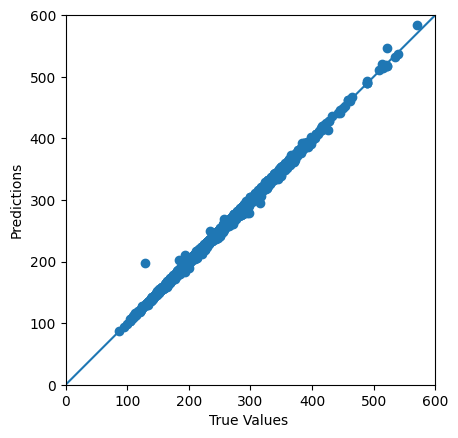

In [41]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values ')
plt.ylabel('Predictions')
lims = [0, 600]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


Histogram of errors:

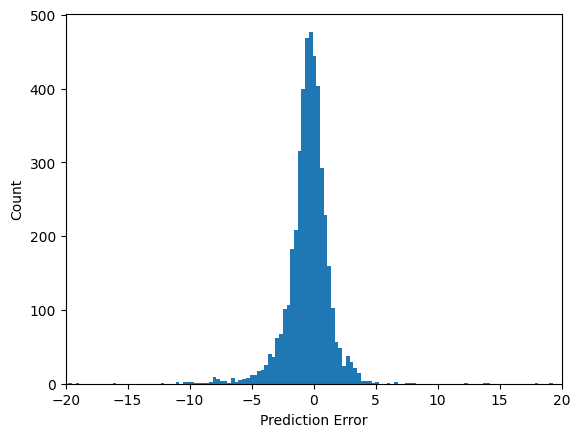

In [42]:
error = test_predictions - test_labels
plt.hist(error, bins=300)
plt.xlim(-20,20)
plt.xlabel('Prediction Error')
_ = plt.ylabel('Count')

Save model:

In [106]:
dnn_model.save('dnn_model.keras')

In summary, it's been fascinating build 4 different ML models to predict fuel emissions. It's been particularly interesting to see the power of DNN's in making predictions. Future work could include: 
* Studying the input features in more detail and possibly doing some feature engineering or removing fetaures that have no effect of the target variable
* Introducing regularization to improve the bias of models both regression and neural network
* Building models to predict other feature like the number of cylinders